In [4]:
# Cell 1: imports and constants
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, 
    roc_auc_score, roc_curve, f1_score
)

DATA_PATH = "C:/Users/quamr/OneDrive/Desktop/project/creditScorePrediction/dataset/loandataset.csv"   # change if needed
RANDOM_STATE = 42

sns.set(style="whitegrid")


In [5]:
# Cell 2: load and quick summary
df = pd.read_csv(DATA_PATH)

print("Dataset Shape:", df.shape)
display(df.head())
print(df.info())
print(df.describe(include="all"))


Dataset Shape: (614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB
None
         Loan_ID Gender Married Dependents Education Self_Employed  \
count        614    601     611      

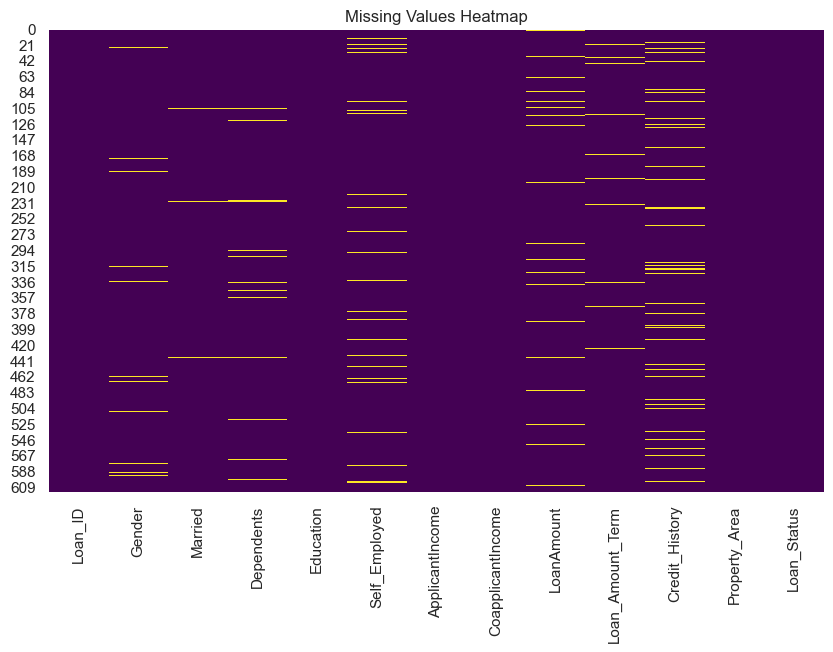

In [6]:
# Cell 3: missing values heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()


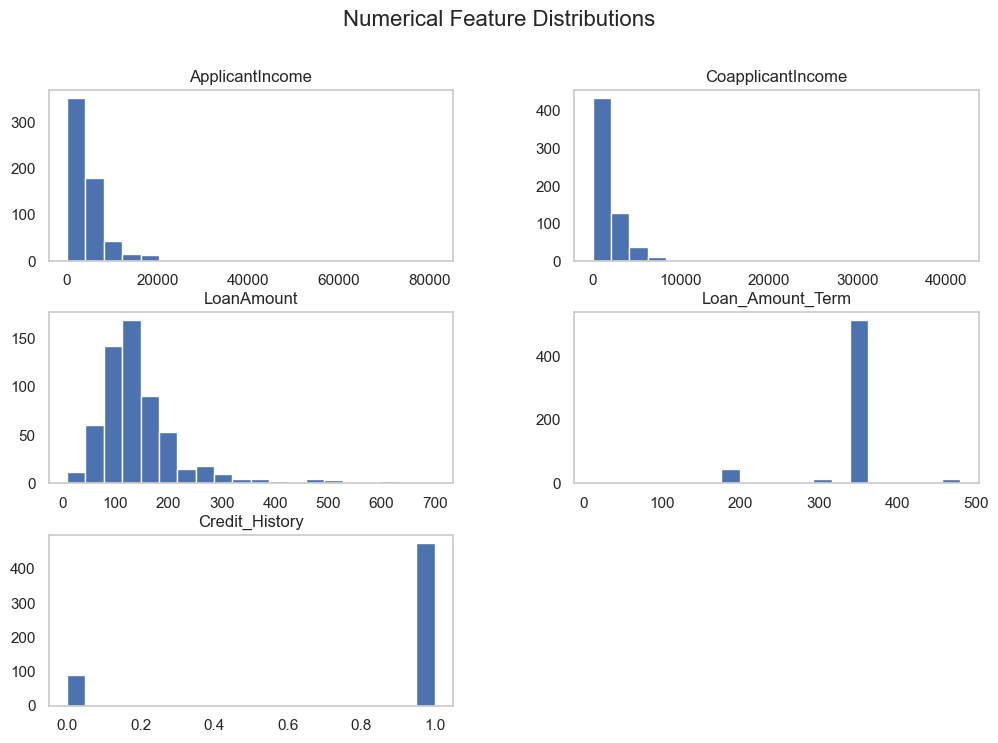

In [7]:
# Cell 4: distribution of numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns

df[numeric_cols].hist(figsize=(12,8), bins=20, grid=False)
plt.suptitle("Numerical Feature Distributions", fontsize=16)
plt.show()


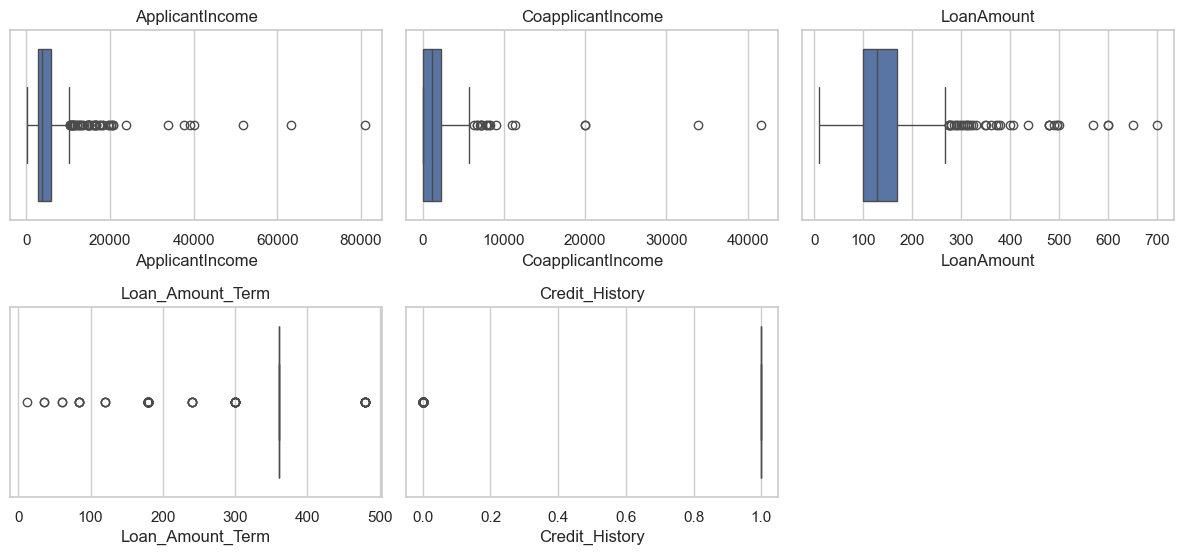

In [8]:
# Cell 5: boxplots
plt.figure(figsize=(12,8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()


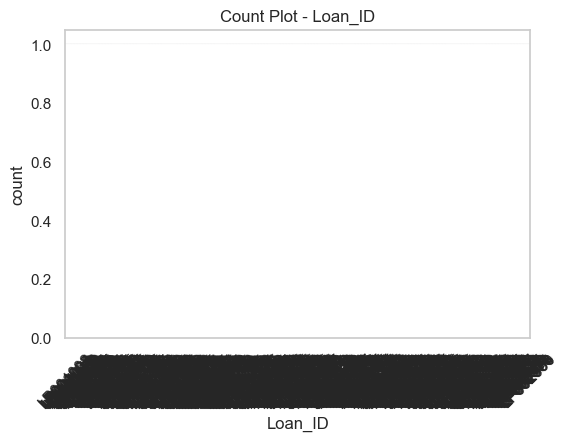

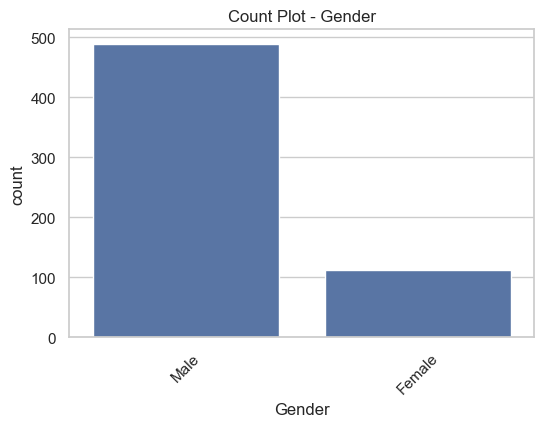

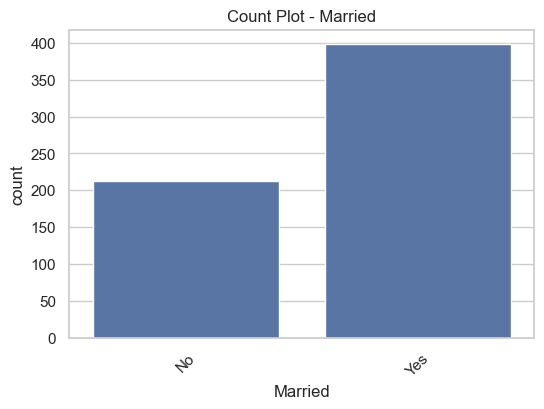

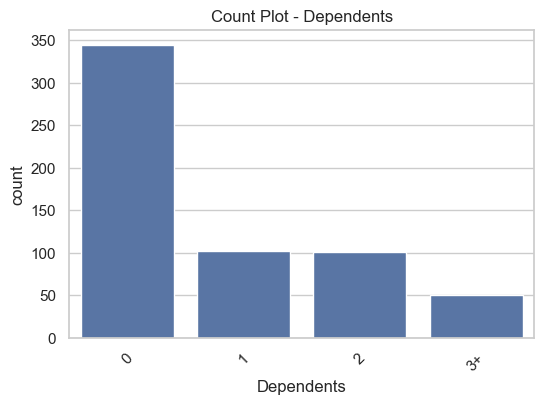

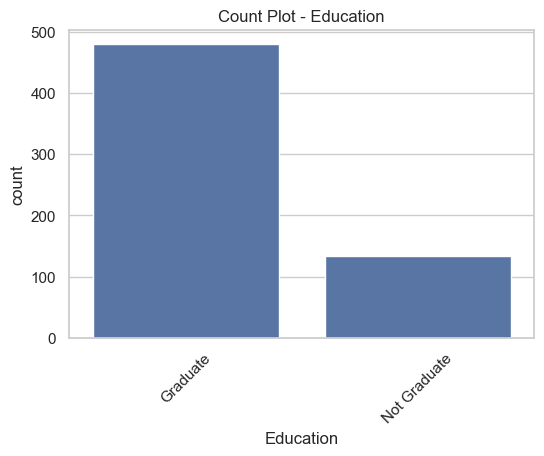

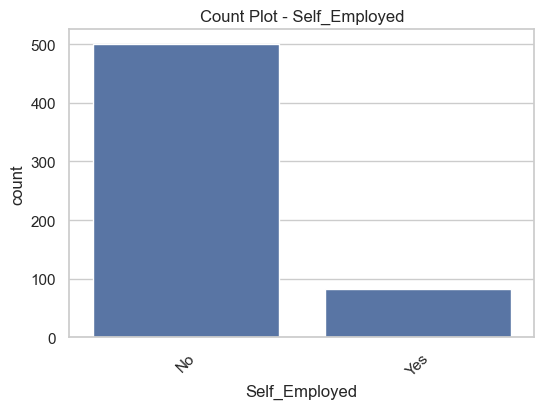

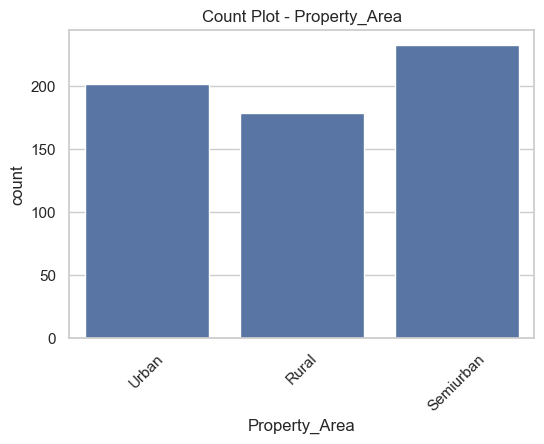

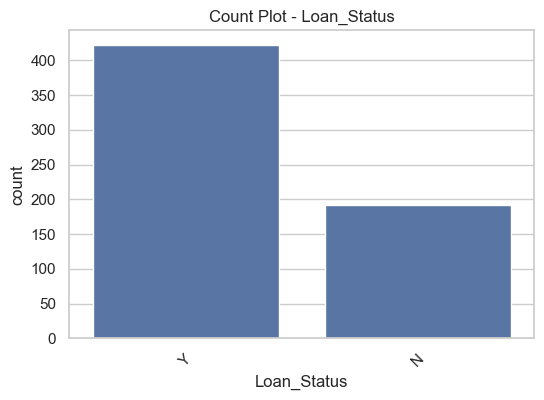

In [9]:
# Cell 6: visualize categorical counts
categorical_cols = df.select_dtypes(include=['object']).columns

for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(data=df, x=col)
    plt.title(f"Count Plot - {col}")
    plt.xticks(rotation=45)
    plt.show()


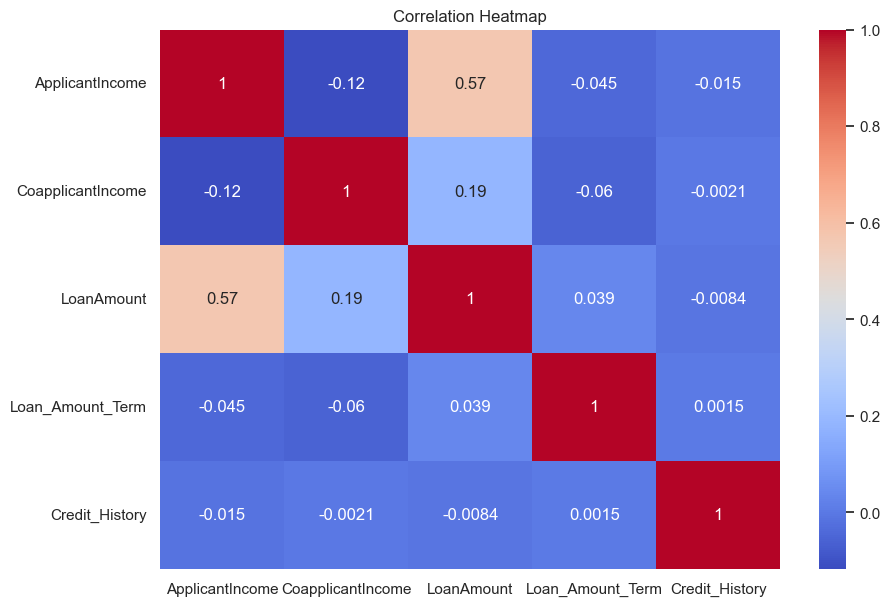

In [10]:
# Cell 7: correlation heatmap
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [11]:
# Cell 8: identify target
possible_targets = [c for c in df.columns if c.lower() in (
    "loan_status","loanstatus","status","approved","loan_approved",
    "target","y","default","loan_default","is_default")]

if possible_targets:
    target_col = possible_targets[0]
else:
    target_col = df.columns[-1]

print("Using target column:", target_col)
print(df[target_col].value_counts())


Using target column: Loan_Status
Loan_Status
Y    422
N    192
Name: count, dtype: int64


In [21]:
# Cell 9: prepare data
X = df.drop(columns=[target_col])
y = df[target_col]

# Convert Yes/No → 1/0 if needed
if y.dtype == object:
    mapping = {"Y":1, "N":0, "Yes":1, "No":0}
    y = y.map(lambda v: mapping.get(str(v), v))

# Encode leftover string labels
if y.dtype == object:
    le = LabelEncoder()
    y = le.fit_transform(y.astype(str))
    joblib.dump(le, "/model/label_encoder.joblib")

X = X.copy()


In [22]:
# Cell 10: separate features
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)


Numeric columns: ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
Categorical columns: ['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']


In [23]:
# Cell 11: preprocessing
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols)
])


In [24]:
# Cell 12: split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (491, 12) Test: (123, 12)


In [25]:
# Cell 13: model training
log_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", LogisticRegression(max_iter=1000, solver="liblinear"))
])

rf_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("clf", RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE))
])

log_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers cont

In [26]:
# Cell 14: evaluation function
def evaluate_model(pipe, X_test, y_test, name="Model"):
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1] if hasattr(pipe, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    print(f"\n==== {name} ====")
    print("Accuracy:", acc)
    print("F1 Score:", f1)
    if auc: print("ROC AUC:", auc)
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return acc, f1, auc



==== Logistic Regression ====
Accuracy: 0.8617886178861789
F1 Score: 0.9081081081081082
ROC AUC: 0.8523219814241486

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.58      0.72        38
           1       0.84      0.99      0.91        85

    accuracy                           0.86       123
   macro avg       0.90      0.78      0.81       123
weighted avg       0.88      0.86      0.85       123



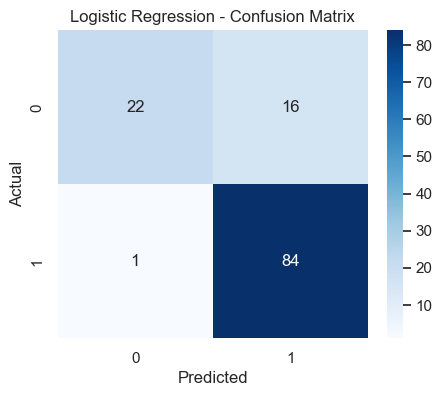


==== Random Forest ====
Accuracy: 0.8455284552845529
F1 Score: 0.8972972972972973
ROC AUC: 0.7956656346749226

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.55      0.69        38
           1       0.83      0.98      0.90        85

    accuracy                           0.85       123
   macro avg       0.87      0.76      0.79       123
weighted avg       0.86      0.85      0.83       123



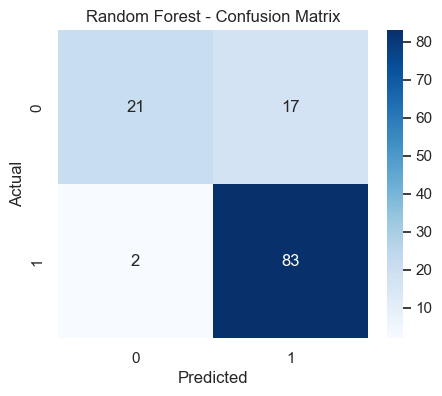

In [27]:
# Cell 15: model evaluation
log_results = evaluate_model(log_pipeline, X_test, y_test, "Logistic Regression")
rf_results  = evaluate_model(rf_pipeline, X_test, y_test, "Random Forest")


In [30]:
import os

# Create model folder if missing
os.makedirs("model", exist_ok=True)

# Save models
joblib.dump(log_pipeline, "model/logistic_pipeline.joblib")
joblib.dump(rf_pipeline, "model/rf_pipeline.joblib")
joblib.dump(preprocessor, "model/preprocessor.joblib")

print("✔ Models saved successfully!")


✔ Models saved successfully!
